# Modelo de Regresión Logística

In [1]:
#from pyspark import SparkContext
#sc = SparkContext()
#from pyspark.sql import SQLContext
#sqlContext=SQLContext(sc)

In [2]:
bd5 = sqlContext.read.format(
    "com.databricks.spark.csv"
).option("header", "true").load("bd5.csv", inferSchema=True)
sqlContext.registerDataFrameAsTable(bd5, "bd5")

In [3]:
from pyspark.ml.feature import VectorAssembler

bd5 = bd5.withColumn('Horario1',(bd5.Horario==1) 
).withColumn('Horario2',(bd5.Horario==2) 
).withColumn('Horario3',(bd5.Horario==3))

# Términos cuadráticos añadidos manualmente
bd5 = bd5.withColumn('DepDelay2',(bd5.DepDelay**2)
).withColumn('DepD_Distance',(bd5.DepDelay * bd5.Distance)) 

## Descripción Previa de la Base de Datos

Resumen Numérico

In [4]:
bd5.select('Retraso').describe().show()

+-------+-------------------+
|summary|            Retraso|
+-------+-------------------+
|  count|              30466|
|   mean| 0.2757500164117377|
| stddev|0.44689875846318494|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [5]:
pdf5 = bd5.sample(False, 0.1, 0).select('Retraso','ArrDelay','DepDelay','DayOfWeek','CRSDepTime').toPandas()
pdf5.corr()

,Retraso,ArrDelay,DepDelay,DayOfWeek,CRSDepTime
Retraso,1.000000,0.650456,0.572242,0.044640,0.179658
ArrDelay,0.650456,1.000000,0.959762,0.055259,0.171944
DepDelay,0.572242,0.959762,1.000000,0.052946,0.156121
DayOfWeek,0.044640,0.055259,0.052946,1.000000,-0.022926
CRSDepTime,0.179658,0.171944,0.156121,-0.022926,1.000000


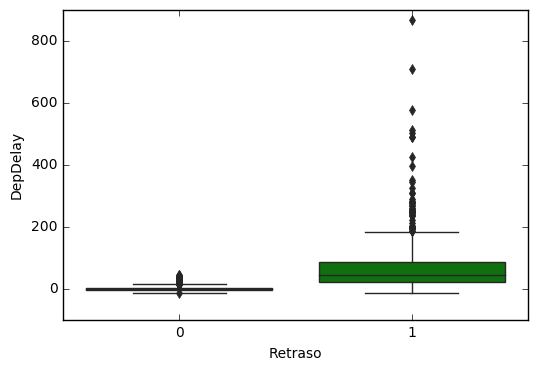

In [6]:
import seaborn as sns
%matplotlib inline

sns.boxplot(x='Retraso',y='DepDelay',data=pdf5)

Configuración de la Base de Datos

In [7]:
from pyspark.sql.functions import col

a1  = VectorAssembler(
    inputCols=['DepDelay','Distance','DayOfWeek',
               'CRSDepTime','Horario1','Horario2',
               'Horario3','DepDelay2','DepD_Distance'],
    outputCol='features')

bd6 = a1.transform(bd5).select(col("Retraso").cast('double').alias("label"),'features')

In [8]:
bd6.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[-5.0,1235.0,4.0,...|
|  0.0|[5.0,1235.0,5.0,8...|
|  0.0|[-3.0,1235.0,6.0,...|
|  0.0|[-7.0,1235.0,7.0,...|
|  0.0|[-6.0,1235.0,1.0,...|
|  0.0|[-1.0,1235.0,2.0,...|
|  0.0|(9,[1,2,3,5],[123...|
|  0.0|(9,[1,2,3,5],[123...|
|  0.0|[-1.0,1235.0,5.0,...|
|  0.0|[-1.0,1235.0,6.0,...|
|  0.0|[1.0,1235.0,7.0,8...|
|  0.0|[-2.0,1235.0,1.0,...|
|  0.0|[-4.0,1235.0,2.0,...|
|  0.0|[-1.0,1235.0,3.0,...|
|  0.0|(9,[1,2,3,5],[123...|
|  0.0|(9,[1,2,3,5],[123...|
|  0.0|[13.0,1235.0,6.0,...|
|  0.0|[17.0,1235.0,7.0,...|
|  0.0|[12.0,1235.0,1.0,...|
|  0.0|[19.0,1235.0,2.0,...|
+-----+--------------------+
only showing top 20 rows



## Ajuste del modelo

In [9]:
from pyspark.ml.classification import LogisticRegression

lgr = LogisticRegression(maxIter=10, 
     labelCol="label", 
     featuresCol="features",
     threshold=0.5)
                        
model = lgr.fit(bd6)

In [10]:
print(model.intercept,model.coefficients)

-1.6228762950366733 [0.0174818630425,-0.000153907645432,0.00622037724017,0.000243814478493,-0.18527035429,0.0280656797875,0.0553254124157,1.4042617353e-06,9.64852764749e-06]


Los valores predichos se obtienen de:

$p_i = \frac{e^{X_i\beta}}{1+e^{X_i\beta}}$

Siendo $X_i\beta  = \beta_0 + \beta_1 X_{1i} + ... \beta_p X_{pi}$ los valores de raw_prediction.

Los valores de raw_prediction se obtienen a partir de los coeficientes del modelo y las correspondientes variables explicativas

In [11]:
pred = model.transform(bd6)
pred.select('rawPrediction','probability').show(20)


/usr/lib/spark/python/pyspark/ml/classification.py:207: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")


+--------------------+--------------------+
|       rawPrediction|         probability|
+--------------------+--------------------+
|[1.70093568096363...|[0.84565690072126...|
|[1.40073735685147...|[0.80230086988420...|
|[1.62972180529665...|[0.83613152532732...|
|[1.74103643633586...|[0.85081866429966...|
|[1.74897916049225...|[0.85182399800571...|
|[1.59581895897683...|[0.83143321551653...|
|[1.56020219131119...|[0.82638236420325...|
|[1.55398181407102...|[0.82548808566343...|
|[1.57715782725631...|[0.82880162030731...|
|[1.57093745001614...|[0.82791720811509...|
|[1.50592148340157...|[0.81845598417189...|
|[1.63143291811899...|[0.83636583964822...|
|[1.68399127911239...|[0.84343231920939...|
|[1.58959858173665...|[0.83055961883374...|
|[1.55398181407102...|[0.82548808566343...|
|[1.54776143683085...|[0.82459017857110...|
|[1.15913240842384...|[0.76117503319022...|
|[1.03515234102664...|[0.73791356457766...|
|[1.21966719585528...|[0.77200497677627...|
|[1.00735753100816...|[0.7325026

Los valores de *probability* son transformados a *prediction* empleando un punto de corte. 

Por defecto: 0.5

In [12]:
pred.select('label','prediction','probability').show(20)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.84565690072126...|
|  0.0|       0.0|[0.80230086988420...|
|  0.0|       0.0|[0.83613152532732...|
|  0.0|       0.0|[0.85081866429966...|
|  0.0|       0.0|[0.85182399800571...|
|  0.0|       0.0|[0.83143321551653...|
|  0.0|       0.0|[0.82638236420325...|
|  0.0|       0.0|[0.82548808566343...|
|  0.0|       0.0|[0.82880162030731...|
|  0.0|       0.0|[0.82791720811509...|
|  0.0|       0.0|[0.81845598417189...|
|  0.0|       0.0|[0.83636583964822...|
|  0.0|       0.0|[0.84343231920939...|
|  0.0|       0.0|[0.83055961883374...|
|  0.0|       0.0|[0.82548808566343...|
|  0.0|       0.0|[0.82459017857110...|
|  0.0|       0.0|[0.76117503319022...|
|  0.0|       0.0|[0.73791356457766...|
|  0.0|       0.0|[0.77200497677627...|
|  0.0|       0.0|[0.73250269548236...|
+-----+----------+--------------------+
only showing top 20 rows



In [13]:
pred.describe().show()

+-------+-------------------+-------------------+
|summary|              label|         prediction|
+-------+-------------------+-------------------+
|  count|              30466|              30466|
|   mean| 0.2757500164117377|0.10802205737543491|
| stddev|0.44689875846318494| 0.3104133619056151|
|    min|                0.0|                0.0|
|    max|                1.0|                1.0|
+-------+-------------------+-------------------+



### Ajuste

In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator as BCE

evaluator=BCE(rawPredictionCol='rawPrediction',labelCol='label',
              metricName = "areaUnderROC")
#areaUnderPR
evaluator.evaluate(pred)

0.9053308831809781

## Regularización y Selección de Variables

regParam=0, sin penalización (OLS).

elasticNetParam = 0, penalización L2 (Ridge). 

elasticNetParam = 1, penalización L1 (Lasso).

Ridge Regression

In [21]:
lgr = LogisticRegression(maxIter=10, 
     labelCol="label", 
     featuresCol="features",
     regParam=0.5,
     elasticNetParam=0.0)
                        
model = lgr.fit(bd6)
pred = model.transform(bd6)
print(model.intercept,model.coefficients)

-1.3010322347928496 [0.00626416445529,-4.69845926539e-05,0.00776377758017,0.000137146605245,-0.108290451465,-0.00892144636168,0.0343034531299,9.52349580712e-07,3.75833657102e-06]


/usr/lib/spark/python/pyspark/ml/classification.py:207: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")


Lasso Regression

In [16]:
lgr = LogisticRegression(maxIter=10, 
     labelCol="label", 
     featuresCol="features",
     regParam=0.02,
     elasticNetParam=1.0)
                        
model = lgr.fit(bd6)
pred = model.transform(bd6)
print(model.intercept,model.coefficients)

-1.6402992418889197 (9,[0,1,2,8],[0.070204446606,-0.000311812101592,-0.014813395958,7.53966187492e-06])


/usr/lib/spark/python/pyspark/ml/classification.py:207: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")
